In [1]:
import networkx as nx
import numpy as np

def graph_synth(n, p = .2):
    er_graph = nx.fast_gnp_random_graph(n, p)
    while not nx.is_connected(er_graph):
        er_graph = nx.fast_gnp_random_graph(n, p)
    return nx.adjacency_matrix(er_graph).toarray()


def varm_filter(D,x):
    p = D.shape[0]-1
    print(p)
    n = x.shape[0]
    m = x.shape[1]
    y = np.zeros((n,m))
    for i in range(p):
        y[i,:] = x[i,:]
        for k in range(1,i+1):
            y[i,:] = y[i,:] + np.dot(D[k,:,:],y[i-k+1,:].T).T
    for i in range(p,n):
        y[i,:] = x[i,:]
        for k in range(1,p+1):
            y[i,:] = y[i,:] + np.dot(D[k,:,:],y[i-k+1,:].T).T
    return y

def custom_AR_fit(x, P):
    N = len(x)
    r = np.correlate(x,x,mode='full')
    r = r[N-1:]/N
    A_r = np.zeros(P+1)
    A_r[0] = 1
    eps = np.zeros(P+1)
    eps[0] = r[0]
    alpha = np.zeros(P+1)
    alpha[0] = r[1]
    k = np.zeros(P+1)
    k[0] = -alpha[0]/eps[0]
    for i in range(1,P+1):
        A_r = A_r + np.concatenate(([0],k[i-1]*np.flipud(A_r[0:i]),np.zeros(P-i)))
        eps[i] = (1-k[i-1]**2)*eps[i-1]
        alpha[i] = r[i+1]
        for ii in range(1,i+1):
            alpha[i] = alpha[i] + r[(i+1)-ii]*A_r[ii]
        k[i] = -alpha[i]/eps[i]
    return A_r


In [4]:
n = 5
P = 10
D = np.zeros((P+1,n,n))
D[0,:,:] = np.eye(n)
D[P,:,:] = graph_synth(n)*.5
# print(D)

Fs = 200
freqs = [27, 40, 55, 59, 76]
N = 500
x = np.zeros((N,n))
#x is a sine wave
for i in range(int(N/5)):
    for m in range(n):
        x[i,m] = np.sin(i*2*np.pi*freqs[m]/Fs)
x = x + np.random.normal(0,.1,(N,n))


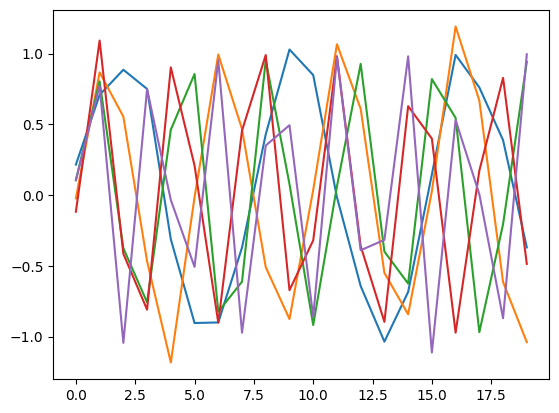

In [5]:
import matplotlib.pyplot as plt
plt.plot(x[0:20,:])

10


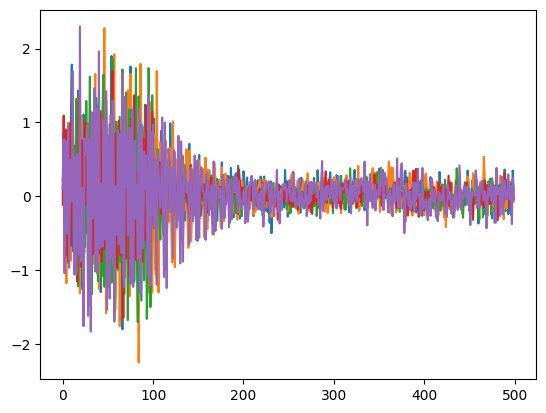

In [6]:
y = varm_filter(D,x)
plt.plot(y)

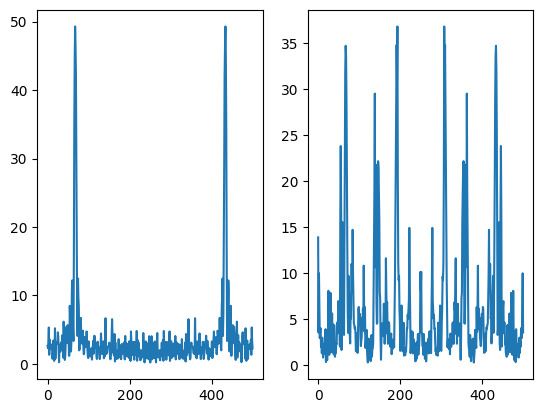

In [7]:
plt.subplot(1,2,1)
plt.plot(np.abs(np.fft.fft(x[:,0])))
plt.subplot(1,2,2)
plt.plot(np.abs(np.fft.fft(y[:,0])))

In [97]:
coeffs = np.zeros((P+1,n))
for i in range(n):
    coeffs[:,i] = custom_AR_fit(y[:,i], P)

print(D[-1,:,:])


errors = []
pairs = []
for i in range(n):
    for j in range(i+1,n):
        errors.append(np.mean((coeffs[:,i]-coeffs[:,j])**2))
        pairs.append([i,j])
sorted_errors = np.sort(errors)
ind = np.argsort(errors)
sorted_pairs = np.concatenate((np.array(pairs)[ind,:]+1,np.array(sorted_errors).reshape(-1,1)),axis=1)
print(sorted_pairs)




[[0.  0.  0.  0.5 0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0.  0.5]
 [0.  0.  0.  0.5 0. ]]
[[2.         3.         0.00579841]
 [3.         4.         0.02372231]
 [4.         5.         0.02417086]
 [1.         3.         0.0411766 ]
 [1.         4.         0.04438814]
 [1.         2.         0.04623889]
 [2.         4.         0.04699206]
 [3.         5.         0.06039726]
 [2.         5.         0.09856017]
 [1.         5.         0.11736362]]
